# Fingerprint recognition project
---
In this project we develope 3 different machine learning method to classify fingerprints in [FCV2004](http://bias.csr.unibo.it/fvc2004/download.asp) fingerprint dataset

## libraries

In [ ]:
!pip install fingerprint-feature-extractor

In [13]:
import numpy as np
import pandas as pd
import fingerprint_feature_extractor # to extract fingerprint minutiae
from sklearn.model_selection import train_test_split

# three classifireas
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier # to prevent multiclass errs
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# visualization libs
import matplotlib.pyplot as plt
import seaborn as sns
from cv2 import imread, resize, imshow, cvtColor, COLOR_BGR2GRAY
import glob
import time


In [3]:
from google.colab import drive
drive.mount('/content/drive/')
%cd drive/MyDrive/fingerprint_project

Mounted at /content/drive/
/content/drive/MyDrive/fingerprint_project


## Load dataset

In [4]:
# load images dataset
def read_image(file_name:str, redimention:tuple = None) -> np.ndarray:
  """load images dataset
  Args:
    file_name (str): address of image file

  raises:
    FileNotFoundError: raise when the file does not exist

  return:
    (np.ndarray): array of readed image 

  """
  img = imread(file_name)
  if isinstance(img, type(None)) :
    raise FileNotFoundError(f"{file_name} does not exist.")
  
  if not isinstance(redimention, type(None)) or not redimention == ():
    img = resize(img, redimention)
  return img

In [5]:
# find paths and files
def path_founder(dir_path:str=None, file_type:str = None) -> list:
  """return list of files or directories
  Args:
    dir_path (str, None): pathes to find a file.

    dir_file_type (str, None): types of file. NOTE: to find directories,
      leave file_type empty. To find all files, set file_type value to *. 
  
  raises:
    TypeError: wront path or type. BAD ADDERSSING.
  
  return:
    (list) : list of files of directory
  """
  if isinstance(file_type, type(None)) or file_type == '':
    path_address ='*'
  else:
    path_address = f"{dir_path}/*.{file_type}"

  file_list = glob.glob(path_address)
  if file_list == []:
    raise TypeError('file or directory does not exist')
  
  return sorted(file_list)

In [6]:
# convert to gray scale
def gray_converter(image_list: np.ndarray) -> np.ndarray:
  gray_list = []
  for image in image_list:
    gray_list.append(cvtColor(image, COLOR_BGR2GRAY))
  
  return np.array(gray_list)

In [7]:
# load dataset
dir_list = path_founder()
image_list = []

for dataset in dir_list:
  file_list = path_founder(dataset,'tif')
  file_list = file_list
  for image_file_name in file_list:
    image_list.append(read_image(image_file_name,redimention=(427, 389)))

image_list = np.array(image_list)
image_list = gray_converter(image_list)

labels = []
# generate labels
for idx in range(320):
  labels.append(idx//8)

labels = np.array(labels)

## classification methods
---
We used 3 different classification method
* KNN: 10 Nearest neighbors
* SVM
* logistic regression

---

all classification methods will add to a sigle dictionary and imported to a pipeline as an argument. so train and test would do automaticly

In [8]:
knn_model = KNeighborsClassifier(n_neighbors=10)

In [9]:
svm_model = SVC()

In [10]:
logistic_model = LogisticRegression(random_state=0)

In [11]:
classifiers = {"KNN":knn_model,
               "SVM" :svm_model,
               "LogisticRegression": logistic_model,
               }

Create a pipeline to make training and test automaticaly with all models

In [23]:
def train_test_pipeline(classifiers: dict,
                        x_train:np.ndarray,
                        y_train:np.ndarray,
                        x_test:np.ndarray,
                        y_test:np.ndarray,
                        ) -> None:
  """ pipeline to automatically train and test classification model

  Args:
    classifiers (dict): dictionay of classifiers contain name and
                 object of classifiers,
    x_train (np.ndarray): array of train data,
    y_train (np.ndarray): array of train labels,
    x_test (np.ndarray): array of test data,
    y_test (np.ndarray): array of test labels,

  """
  for name, clfr in classifiers.items():
    print(f"Fitting with {name} classifire...")
    clfr.fit(x_train, y_train)
    print(f"Fitting done. predicting {name} classifire...")
    y_predict  = clfr.predict(x_test)
    print("calculate accuracy score. ")
    acc_score = accuracy_score(y_test, y_predict)
    accuracy_vector = y_test - y_predict
    print(f"correct predicted:{np.count_nonzero(accuracy_vector==0)}")
    print(f"for {name} classifire accuracy score is {acc_score}\n\n")
    

## Train with raw images

In [ ]:
raw_images_list =  np.reshape(image_list, (320, -1))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(raw_images_list, labels,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    shuffle=True)

In [ ]:
train_test_pipeline(classifiers, x_train, y_train, x_test, y_test)

Fitting with KNN classifire...
Fitting done. predicting KNN classifire...
calculate accuracy score. 
for KNN classifire accuracy score is 0.140625


Fitting with SVM classifire...
Fitting done. predicting SVM classifire...
calculate accuracy score. 
for SVM classifire accuracy score is 0.015625


Fitting with LogisticRegression classifire...
Fitting done. predicting LogisticRegression classifire...
calculate accuracy score. 
for LogisticRegression classifire accuracy score is 0.140625




/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


## Train with extracted features
---
Extract minutiaes of fingerprint with [ Utkarsh-Deshmukh](https://github.com/Utkarsh-Deshmukh/Fingerprint-Feature-Extraction) Fingerprint-Feature-Extraction library.
At frist all extractable minuteate features of an image will extracted,ten first "n" features will picked aplly Principle Component Analysis on them. then results would be ready to train a machine by prefered algorithm.


In [21]:
# extract minutiae feature
def extract_minutiae(image:np.ndarray, n_features:int = 80) -> np.ndarray:
  """extract minutiae features of a finger print.
    finally select the first n features that model builed on. 

  Args: 
    image (np.ndarray): image input
    n_features (int) : number of requeired features

  return:
    (np.ndarray): extraced features
  """
  FeaturesTerminations, FeaturesBifurcations = fingerprint_feature_extractor.extract_minutiae_features(image,
                                                                                                     spuriousMinutiaeThresh=10,
                                                                                                     invertImage=True)
  feature_list = []

  for minutiea_feature in (FeaturesBifurcations, FeaturesTerminations):
    for featuer in minutiea_feature:
      if featuer.Type == 'Bifurcation':
        feature_type = 1
      else:
        feature_type = 0
      feature_list.append([featuer.locX,
                           featuer.locY,
                           feature_type, 
                           featuer.Orientation[0],  
                           ])
  
  # select first n features 
  if len(feature_list) < n_features:
    # zero pad to meen n_features requiement
    for _ in range(len(feature_list),n_features):
      feature_list.append([0,0,0,0])
  else:
    feature_list = feature_list[:n_features]


  return np.array(feature_list)



In [15]:
def apply_pca(x:np.ndarray, n_components:int = 40)-> np.ndarray:
  """ Apply PCA on dataset. 

    Args:
      x (np.ndarray): extracted feature dataset
      n_components (int): number of features to select

    returns:
      (np.ndarray): array of features extracted
  """
  # define scaler. 
  scaler = StandardScaler()
  scaled_data = scaler.fit_transform(x)
  # define pca object
  pca = PCA(n_components = n_components)
  x_pca = pca.fit_transform(scaled_data)

  return x_pca


In [22]:
# extract minuteate features from image dataset
extracted_feature_list = []
for img in image_list[:80]:
  image_minutea_feature = extract_minutiae(img)
  image_minutea_feature = np.reshape(image_minutea_feature, -1)
  extracted_feature_list.append(image_minutea_feature)

# convert list of featurs to an array
extracted_feature_list = np.array(extracted_feature_list)

In [24]:
dimension_reduced = apply_pca(extracted_feature_list, n_components=40)

In [27]:
#apply LDA
LDA_model = LDA()
dimension_reduced = LDA_model.fit_transform(extracted_feature_list,labels[:80])

In [28]:
x_train, x_test, y_train, y_test = train_test_split(dimension_reduced,
                                                    labels[:80],
                                                    test_size=0.20,
                                                    random_state=0,
                                                    shuffle=True)

In [29]:
train_test_pipeline(classifiers, x_train, y_train, x_test, y_test)

Fitting with KNN classifire...
Fitting done. predicting KNN classifire...
calculate accuracy score. 
correct predicted:8
for KNN classifire accuracy score is 0.5


Fitting with SVM classifire...
Fitting done. predicting SVM classifire...
calculate accuracy score. 
correct predicted:10
for SVM classifire accuracy score is 0.625


Fitting with LogisticRegression classifire...
Fitting done. predicting LogisticRegression classifire...
calculate accuracy score. 
correct predicted:10
for LogisticRegression classifire accuracy score is 0.625




In [ ]:
# show image sample
image_sample = image_list[21]
image_sample_minutiae = extract_minutiae(image_sample, n_features=80)
image_sample_minutiae = np.reshape(image_minutea_feature,-1)
x = image_sample_minutiae[0::4]
y = image_sample_minutiae[1::4]


In [ ]:
y=y-np.min(y)+125

In [ ]:
y_scaler = MinMaxScaler()

In [ ]:
y = np.reshape(y,(-1,1))
y

In [ ]:
y=y_scaler.fit_transform(y)

In [ ]:
y = y*(230-125) + 125

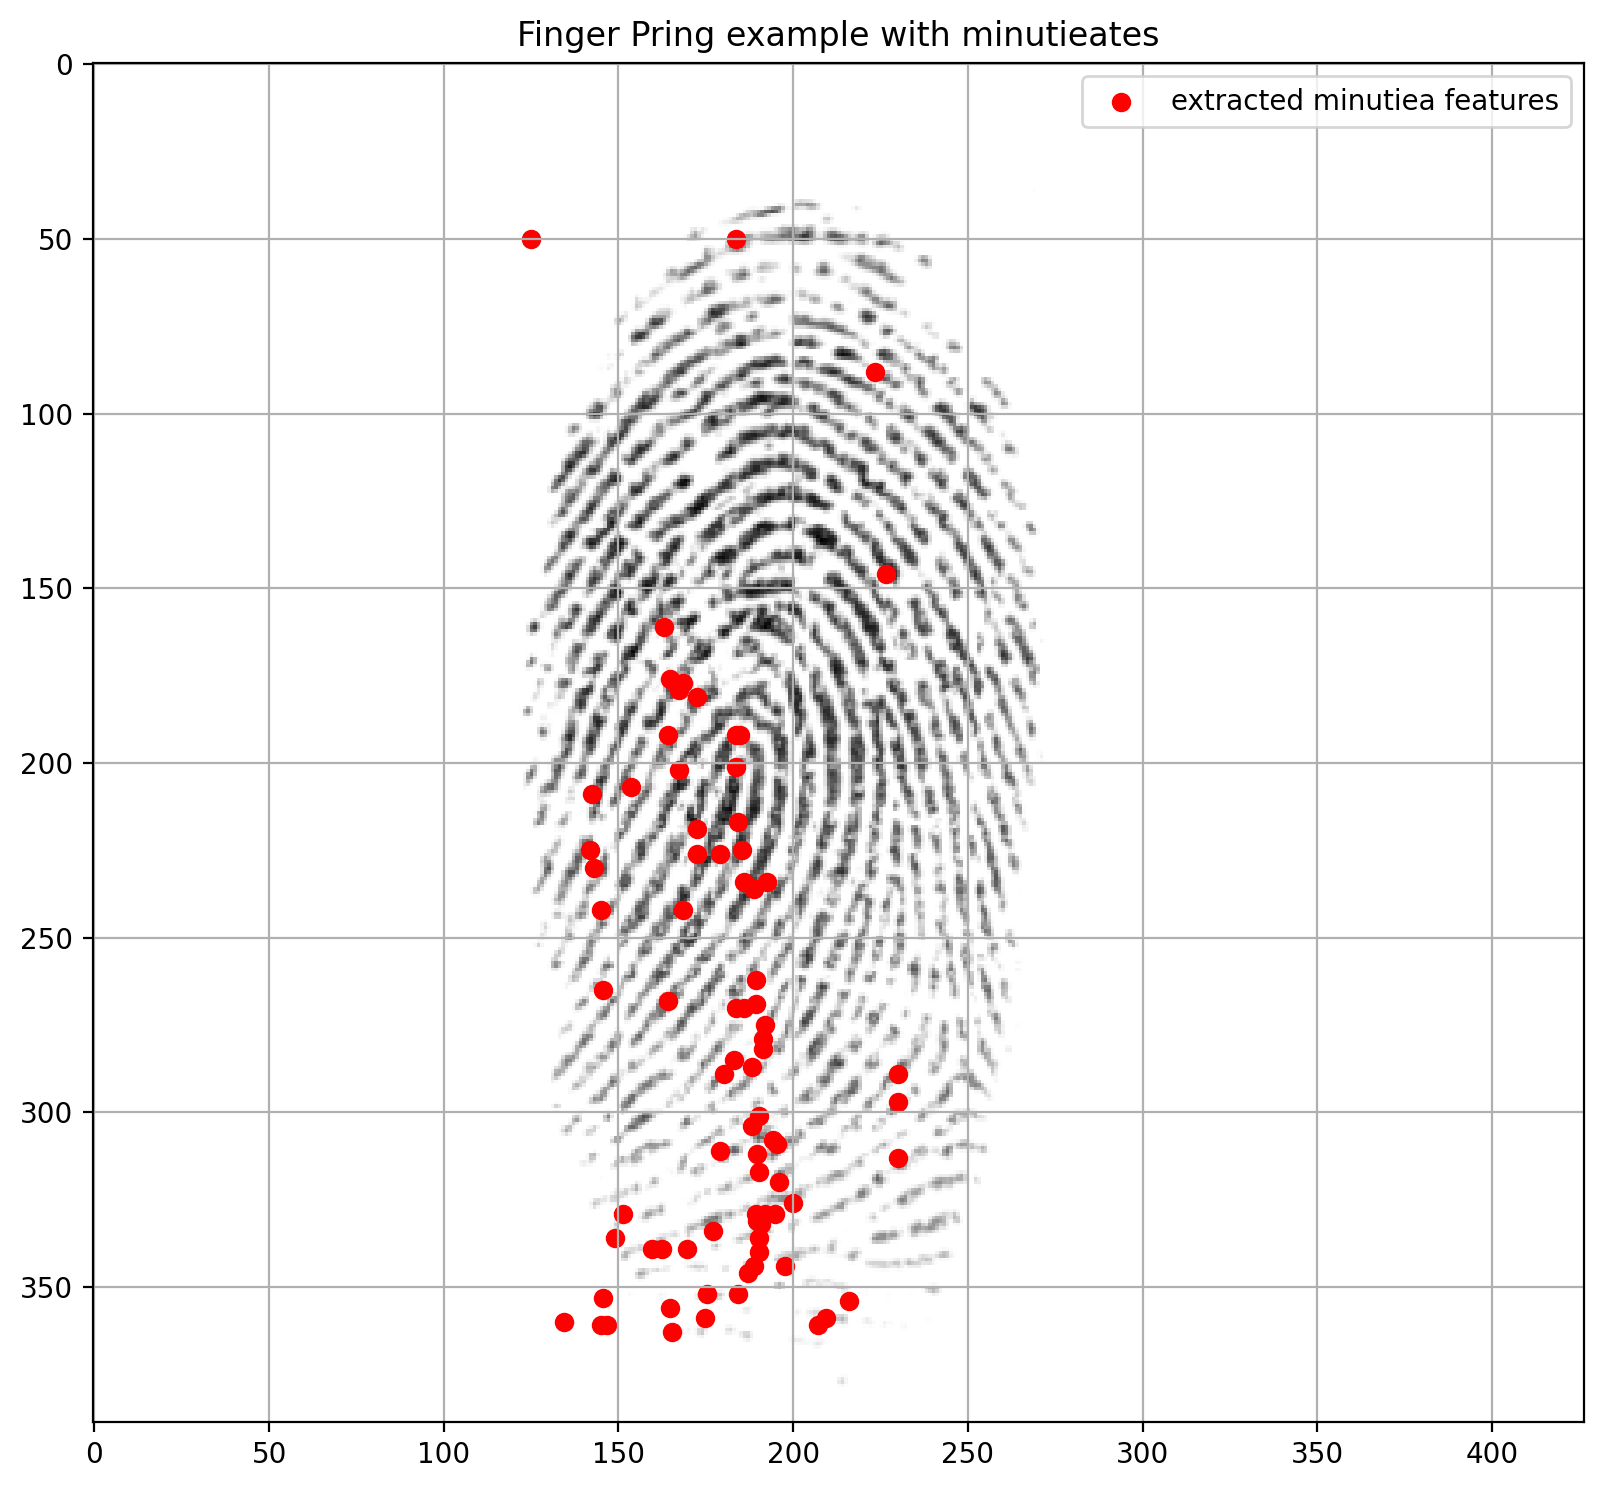

In [ ]:
plt.figure(figsize=(16,9),dpi=200)
plt.imshow(image_sample, cmap = "gray", label= 'image 21')
plt.scatter(y,x,c='red', label= 'extracted minutiea features')
plt.grid()
plt.title("Finger Pring example with minutieates")
plt.legend()
plt.show()